In [28]:
import sys
if not sys.argv[1] == "-f":
    path = sys.argv[1]
    mode = "commandline"
else:
    # 手動で解析する場合はデータのあるpathを指定してください
    path = "/home/amigos/hdd/data/observation/rsky/20190918_160218"
    mode = "notebook"

In [29]:
import necstdb
import numpy
import matplotlib.pyplot as plt
import os
import pandas

In [30]:
topicname = [
"xffts_board01",
"xffts_board02",
"xffts_board03",
"xffts_board04",
"xffts_board05",
"xffts_board06",
"xffts_board07",
"xffts_board08",
"xffts_board09",
"xffts_board10",
"xffts_board11",
"xffts_board12",
"xffts_board13",
"xffts_board14",
"xffts_board15",
"xffts_board16"
]

In [31]:
def get_tsys(dhot, dsky, thot):
    y = dhot / dsky
    tsys = thot / (y - 1.)
    return tsys

In [32]:
%%time
hot_list = []
sky_list = []
tsys_list = []
for i in topicname:
    n = necstdb.opendb(path)
    #print(n.list_tables())
    nn = n.open_table("obsmode")
    dd = n.open_table(i)
    obsmode = numpy.array(nn.read())
    spec_array = numpy.array(dd.read())

    timestamp = obsmode[:,0]
    obsmode2 = list(map(lambda x:x.decode(), obsmode[:,1].tolist()))

    obsmode2 = numpy.array(obsmode2)
    hotmask = obsmode2 == "HOT"
    skymask = obsmode2 == "SKY"

    array = spec_array.T[2:].T
    array_timestamp = spec_array.T[1].T

    start_time = timestamp[hotmask][0]
    end_time = timestamp[hotmask][-1]

    start_time2 = timestamp[skymask][0]
    end_time2 = timestamp[skymask][-1]

    print(array_timestamp[0])
    st_index = numpy.where(array_timestamp > float(start_time))[0][0]#分光データのtimstampから切り出す部分の始め
    end_index = numpy.where(array_timestamp < float(end_time))[0][-1]# 終わり
    st_index2 = numpy.where(array_timestamp > float(start_time2))[0][0]#分光データのtimstampから切り出す部分の始め
    end_index2 = numpy.where(array_timestamp < float(end_time2))[0][-1]# 終わり

    tm = array[st_index:end_index]#要注意　切り出しデータ
    hot = numpy.mean(tm, axis=0)
    tm2 = array[st_index2:end_index2]#要注意　切り出しデータ
    sky = numpy.mean(tm2, axis=0)
    hot_list.append(hot)
    sky_list.append(sky)
    tsys_list.append(get_tsys(hot, sky, 300))


1568822543.9546785
1568822543.9546785
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.8755515
1568822543.9546785
1568822543.9546785
CPU times: user 1.56 s, sys: 220 ms, total: 1.78 s
Wall time: 2.53 s


In [33]:
fig = plt.figure(figsize=(16,16))
ax = [fig.add_subplot(4, 4, i+1) for i in range(16)]
x = numpy.linspace(0, 2000, 32768)#XFFTS bw = 0-2000MHz
    
# plot hot
for i, (_ax, _tsys) in enumerate(zip(ax, tsys_list)):
    _ax.plot(x, hot_list[i], "r-", label="hot")
    _ax.plot(x, sky_list[i], "b-", label="sky")
    _ax0 = _ax.twinx()
    _ax0.plot(x, tsys_list[i], "g.", label="Tsys", alpha=0.1)
    _ax.set_xlabel('frequency [MHz]')
    _ax.set_ylabel("count")
    _ax.set_yscale("log")
    _ax0.set_ylabel('Tsys [K]')
    _ax.set_title('IF : {}'.format(i+1))
    tsys_av = numpy.mean(_tsys)
    _ax.text(0.05, 0.05, 'Tsys = %.2f'%(tsys_av), transform=_ax0.transAxes)
    _ax0.set_ylim(0, 600)
    _ax.legend()
    _ax.grid()

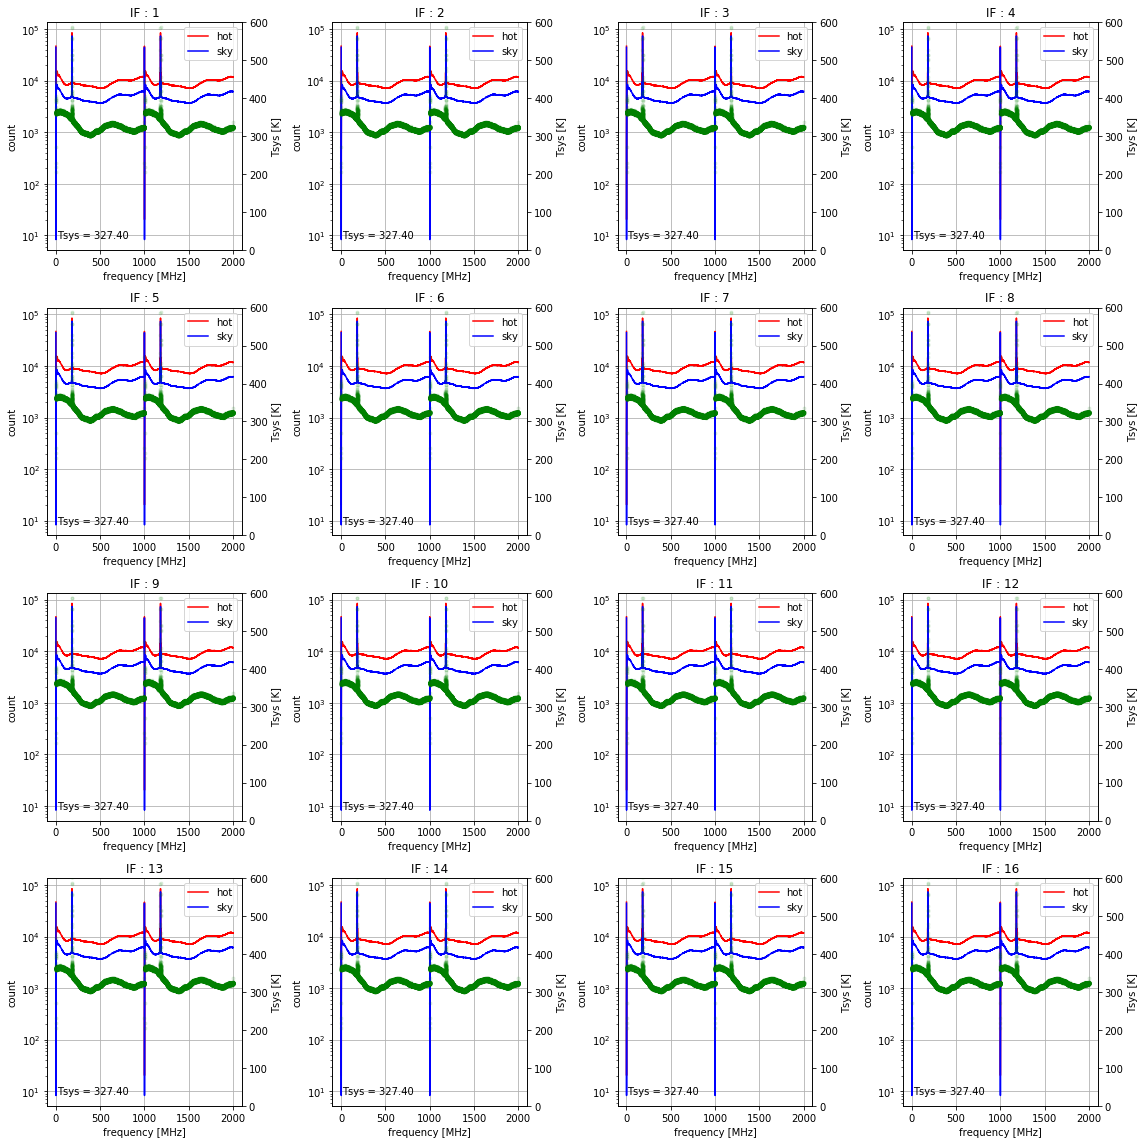

In [34]:
plt.tight_layout()
result_path = path.replace("data", "analysis")
if not os.path.exists(result_path):
    os.makedirs(result_path, exist_ok=True)
plt.savefig(os.path.join(result_path, "result_rsky.png"))
if mode == "notebook":
    plt.show()